# Build VARMA model for econometric data

**The dataset is the quarterly records for different US macroeconomies:**

* **GDPC96** is the Gross Domestic Product, which is the total market value of goods and services produced within the US every three months
    
* **JAPAN_IP** is the total of production industry coming from Japan

* **PCECTPI** is the Chain-type Price Index

* **GS10** is Goldman Sachs long-term fixed rate investment

* **GS1** is Goldman Sachs fixed rate investment

* **TB3MS** is the 3 Month Treasury Bill Rate (short-term fixed rate investment)

* **UNRATE** is the Unemployment Rate

* **EXUSUK** is the U.K. Foreign Exchange Rate

* **CPIAUCSL** is the Consumer Price Index for All Urban Consumers
    
**As you can see, all the time series have different scales and are measured in different units. You will need to normalize the inputs.**

**To calculate the Term Spread, you need to be familiar with fixed-rate investments, e.g. HSBC fixed rate savings accounts. The spread is the difference between the long-term investment and short-term investment rates.**

    term spread = long-term rate - short-term rate
    
**The pattern should be that short-term investments usually have lower interest rates than long-term investments. This is because you are rewarded for investing your money for longer periods of time. The difference between the two rates will fluctuate over time, and can be nearly be the same at several points in time. The GDP and Term Spread time series may be related...**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
# Warning message is an issue with Excel files

df = pd.read_excel('data/us_macro_quarterly.xlsx')

C:\Users\shmel\Anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [3]:
df.head()

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


In [4]:
# Function to re-format and parse date times - define quarter as 3 months

def parse_date(data):
    # Quarterly is {01, 02, 03, 04} 
    year, quarter = data.split(':') 
    month = (int(quarter) - 1) * 3 + 1 
    s = f"{year}-{month}" 
    return datetime.strptime(s, "%Y-%m")

In [5]:
df['Date'] = df['Unnamed: 0'].apply(parse_date)

In [6]:
df.set_index(df['Date'], inplace=True)

# Remove unwanted columns
df.drop(['Date', 'Unnamed: 0'], axis=1, inplace=True)

In [7]:
# Set quarterly index frequency

df.index.freq = 'QS'

In [8]:
# Note that months now go up by 3 each time, i.e. quarterly

df.head()

,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
Date,,,,,,,,,
1957-01-01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1957-04-01,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
1957-07-01,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
1957-10-01,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
1958-01-01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


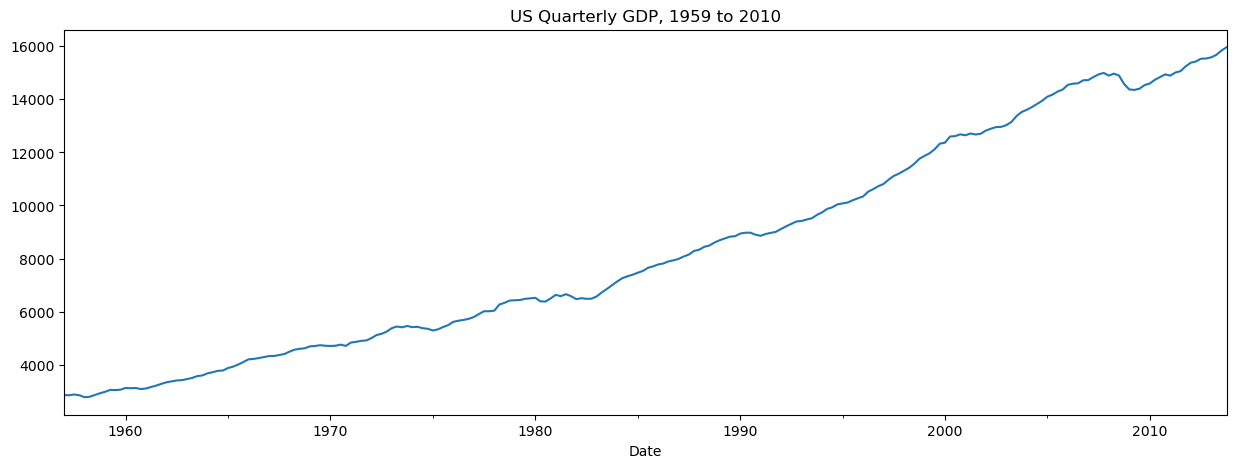

In [9]:
# Plot US GDP

df['GDPC96'].plot(figsize=(15, 5))
plt.title("US Quarterly GDP, 1959 to 2010");

**The GDP seems to have a strong linear trend, i.e. it is not stationary. You will need to apply 'differencing' before using in the model.**

In [10]:
# Calculate GDP growth as log of GDP (differenced once)

df['GDPGrowth'] = np.log(df['GDPC96']).diff()

In [11]:
# Calculate Term Spread

df['TSpread'] = df['GS10'] - df['TB3MS']

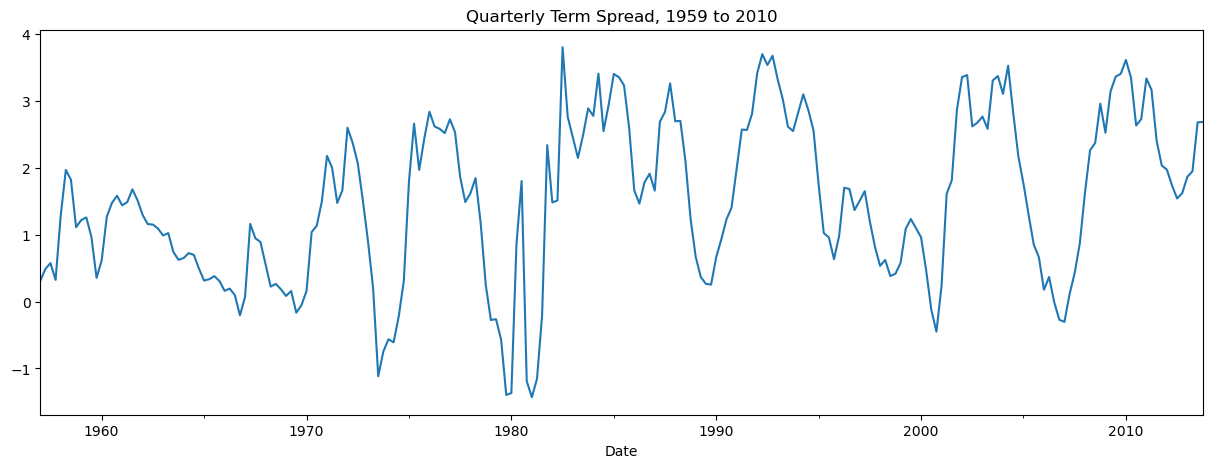

In [12]:
# Plot Term Spread

df['TSpread'].plot(figsize=(15, 5))
plt.title("Quarterly Term Spread, 1959 to 2010");

**As you can see, the term spread fluctuates over time with the difference between the two investment rates being zero at many points in time. There is no upwards or downwards trend, so it may be stationary, but there does seem to be a cyclical pattern in the fluctuations.**

**The multiple time series you will forecast for are GDP Growth and Term Spread.**

In [16]:
df.head()

,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL,GDPGrowth,TSpread
Date,,,,,,,,,,,
1957-01-01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667,NaN,0.306667
1957-04-01,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333,-0.002220,0.486667
1957-07-01,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333,0.009693,0.573333
1957-10-01,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000,-0.010303,0.323333
1958-01-01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667,-0.026265,1.283333


In [13]:
cols = ['GDPGrowth', 'TSpread']

In [14]:
# Make copy of model data with selected time series only - start from 2nd row to remove null value

df1 = df.iloc[1:][cols].copy()

In [15]:
df1.head()

,GDPGrowth,TSpread
Date,,
1957-04-01,-0.002220,0.486667
1957-07-01,0.009693,0.573333
1957-10-01,-0.010303,0.323333
1958-01-01,-0.026265,1.283333
1958-04-01,0.006577,1.966667


In [17]:
# Create training and test sets

N_test = 12

train = df1.iloc[: -N_test].copy()
test = df1.iloc[-N_test :].copy()

In [18]:
# Boolean index training and test sets against original data

train_idx = df1.index <= train.index[-1]

test_idx = ~train_idx

## Normalize data

In [19]:
# Overwrite original data, unless you want to preserve them

scaler = StandardScaler()

train[cols] = scaler.fit_transform(train)

test[cols] = scaler.transform(test)

In [20]:
train.head()

,GDPGrowth,TSpread
Date,,
1957-04-01,-1.094132,-0.804627
1957-07-01,0.219378,-0.732834
1957-10-01,-1.985286,-0.939930
1958-01-01,-3.745106,-0.144679
1958-04-01,-0.124216,0.421386


In [21]:
# Overwrite values in df1 also, since originals are not needed

df1.loc[train_idx, :] = train
df1.loc[test_idx, :] = test

In [22]:
df1.head()

,GDPGrowth,TSpread
Date,,
1957-04-01,-1.094132,-0.804627
1957-07-01,0.219378,-0.732834
1957-10-01,-1.985286,-0.939930
1958-01-01,-3.745106,-0.144679
1958-04-01,-0.124216,0.421386


## Plot ACF and PACF

**With VARMA model, the ACF and PACF is simply a rough guide, since they are not enough to determine `p` & `q` values for the model. We cannot take into consideration any crossing-over between the multiple time series.**

### GDP Growth

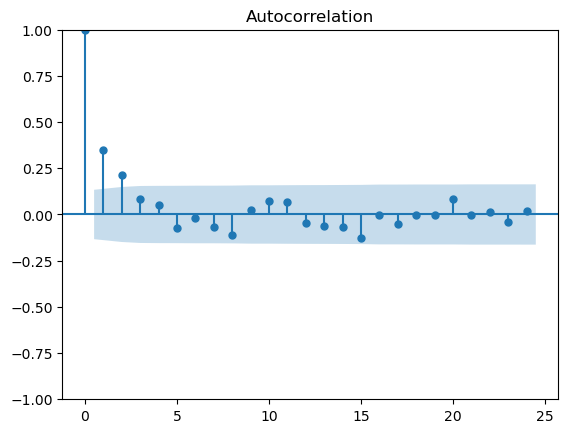

In [23]:
plot_acf(train['GDPGrowth']);

**Based on GDP growth alone, the ACF suggests a small `q` value, approx. 2 lags in past errors.**

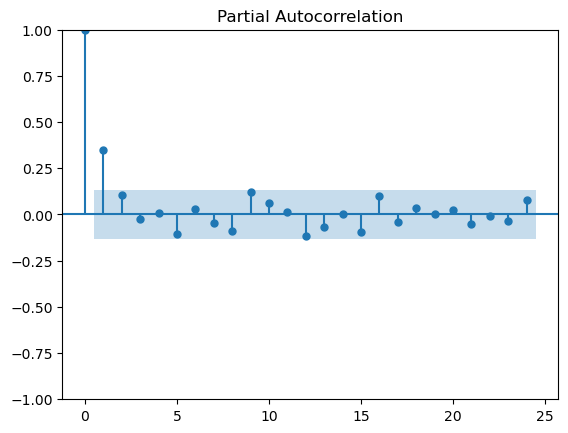

In [24]:
plot_pacf(train['GDPGrowth'], method='ywm');

**For GDP growth, the PACF suggests a low `p` value of 1 lag in past values.**

### Term Spread

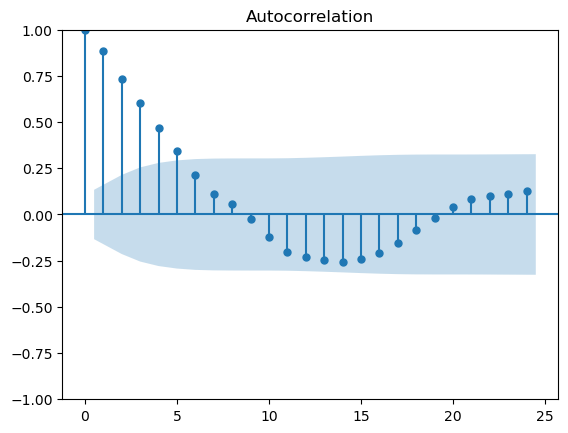

In [25]:
plot_acf(train['TSpread']);

**The ACF for the term spread has a cyclical pattern, as seen in the term spread plot, but significant correlation stays in the earlier lags, `q` value of 4 or 5 lags in past errors.**

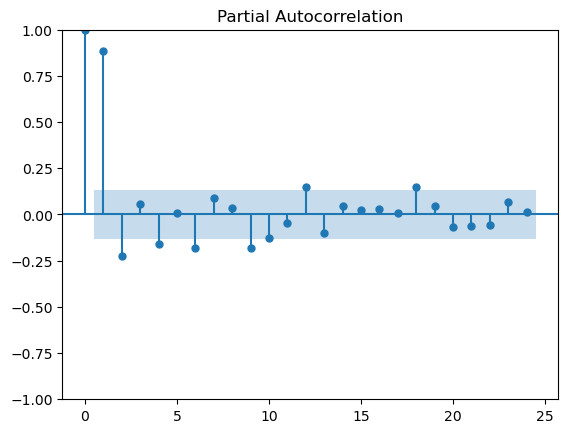

In [26]:
plot_pacf(train['TSpread'], method='ywm');

**This time, a few more lags are somewhat significant, suggesting more dependence on past values for the Term Spread with `p` value of approx. 9 lags.**

**Arbitrarily, I will choose a higher `p` value for the VARMA model of 10 lags, and a smaller `q` value of 4 lags.**

## Check for stationarity in each time series

In [27]:
if adfuller(train['GDPGrowth'])[1] < 0.05:
    print("GDP growth is stationary")
else:
    print("GDP growth is not stationary")

GDP growth is stationary


In [28]:
if adfuller(train['TSpread'])[1] < 0.05:
    print("Term Spread is stationary")
else:
    print("Term Spread is not stationary")

Term Spread is stationary


**You can also see which time series is less or more stationary - for those time series that are less stationary may show more inaccuracies in the model. It is important to note, as it may improve model performance to 'difference' the time series.**

## Build VARMA model

In [29]:
# Set arbitrary p & q values

p = 10
q = 4

In [30]:
t0 = datetime.now()

model = VARMAX(train, order=(p, q))

res = model.fit(maxiter=300)

print("Duration:", datetime.now() - t0)

C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 0:00:34.794454


In [31]:
fcast = res.get_forecast(N_test)

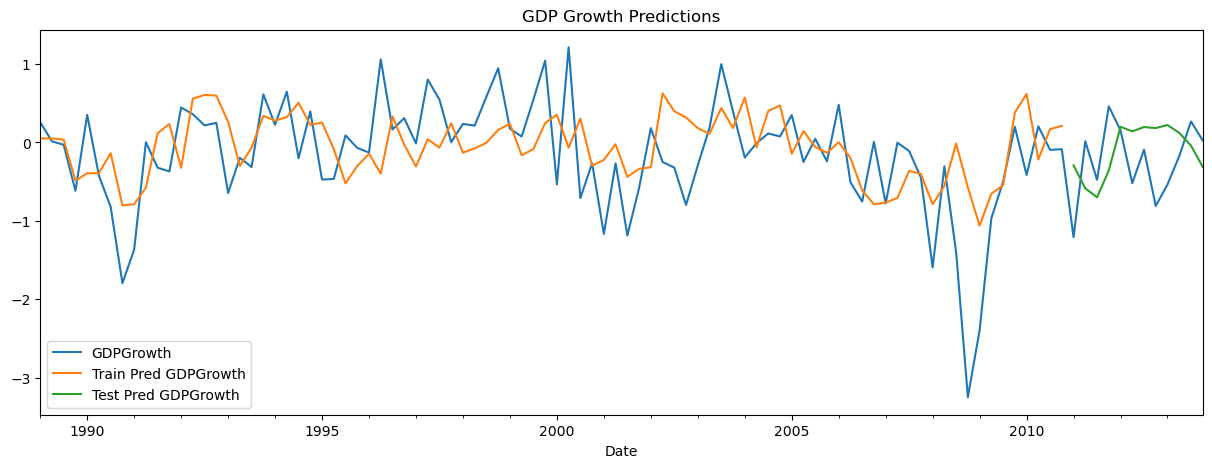

In [32]:
# Add all predictions to df1 and plot

df1.loc[train_idx, 'Train Pred GDPGrowth'] = res.fittedvalues['GDPGrowth']
df1.loc[test_idx, 'Test Pred GDPGrowth'] = fcast.predicted_mean['GDPGrowth']

plot_cols = ['GDPGrowth', 'Train Pred GDPGrowth', 'Test Pred GDPGrowth']

# Plot last 100 rows to view more closely
df1.iloc[-100:][plot_cols].plot(figsize=(15, 5))
plt.title("GDP Growth Predictions");

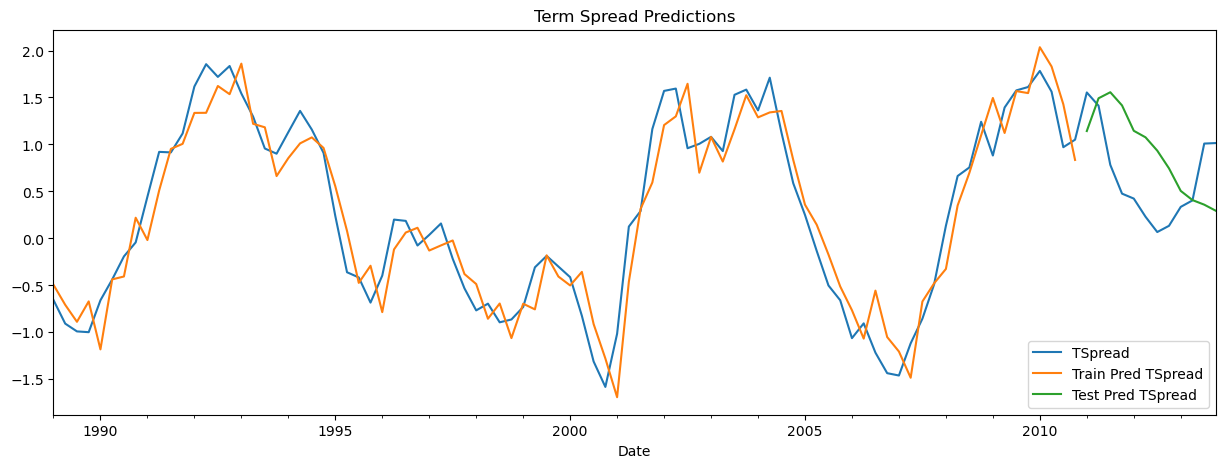

In [33]:
df1.loc[train_idx, 'Train Pred TSpread'] = res.fittedvalues['TSpread']
df1.loc[test_idx, 'Test Pred TSpread'] = fcast.predicted_mean['TSpread']

plot_cols = ['TSpread', 'Train Pred TSpread', 'Test Pred TSpread']

df1.iloc[-100:][plot_cols].plot(figsize=(15, 5))
plt.title("Term Spread Predictions");

**Training predictions follow the true data more closely for Term Spread, but the predictions are not a good fit for GDP Growth. The model seems to have trouble predicting the more extreme values, even in the Term Spread training set. This shows the same behaviour as stock prices, where too much randomness is difficult to forecast for both the GDP Growth and Term Spread. However, it is worth noting that the general direction or trend has been captured for both time series.**

**NOTE: Naive forecasting would entail predicting the last known training value, so it seems that this model does perform a little better from the outlook.**

## Compute R-Squared metric

**Note that the GDP Growth training and test scores appear first in the For Loop, then the Term Spread training and test scores:** 

In [34]:
for col in cols:
    y_true = df1.loc[train_idx, col]
    y_pred = res.fittedvalues[col]
    print("Train R2:", r2_score(y_true, y_pred))
    
    y_true = df1.loc[test_idx, col]
    y_pred = fcast.predicted_mean[col]
    print("Test R2:", r2_score(y_true, y_pred))

Train R2: 0.2428876152229048
Test R2: -0.6856758841108193
Train R2: 0.8644040160551013
Test R2: -0.8475405753054153


**Yikes! The model is not performing with great accuracy, with negative test scores for both time series. This means that predicting the average value would have performed better than the model. Even though the training score for Term Spread is high (approx. 86%), the test score is very close to -1, indicating that the model does not fit the data at all.**

## Compare to VAR model

**Rather than perform a grid search to find optimum p and q values, it is worth testing another vectored model like `VAR`.**

In [37]:
train.head()

,GDPGrowth,TSpread
Date,,
1957-04-01,-1.094132,-0.804627
1957-07-01,0.219378,-0.732834
1957-10-01,-1.985286,-0.939930
1958-01-01,-3.745106,-0.144679
1958-04-01,-0.124216,0.421386


In [35]:
model = VAR(train)

In [36]:
lag_order_results = model.select_order(maxlags=20)

# If you use AIC, the lag order p is 10 (2.5 years)
lag_order_results.selected_orders

{'aic': 10, 'bic': 1, 'hqic': 2, 'fpe': 10}

In [38]:
results = model.fit(maxlags=20, ic='aic')

In [39]:
lag_order = results.k_ar

In [40]:
lag_order

10

In [41]:
prior = train.iloc[-lag_order:][cols].to_numpy()

fcast = results.forecast(prior, N_test)

### Plot time series predictions

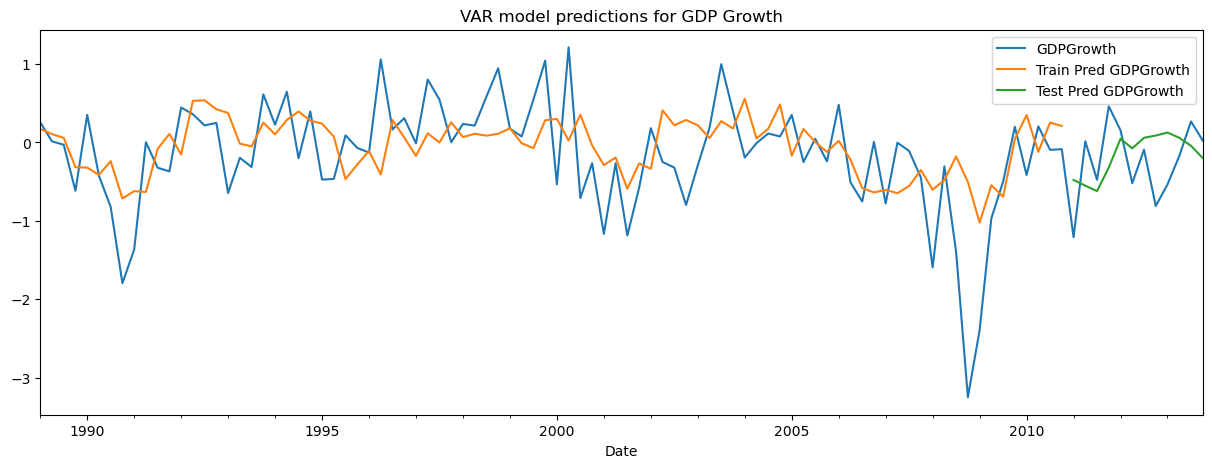

In [42]:
# Plot GDP Growth predictions

df1.loc[train_idx, 'Train Pred GDPGrowth'] = results.fittedvalues['GDPGrowth']
df1.loc[test_idx, 'Test Pred GDPGrowth'] = fcast[:,0]

plot_cols = ['GDPGrowth', 'Train Pred GDPGrowth', 'Test Pred GDPGrowth']

df1.iloc[-100:][plot_cols].plot(figsize=(15, 5))
plt.title("VAR model predictions for GDP Growth");

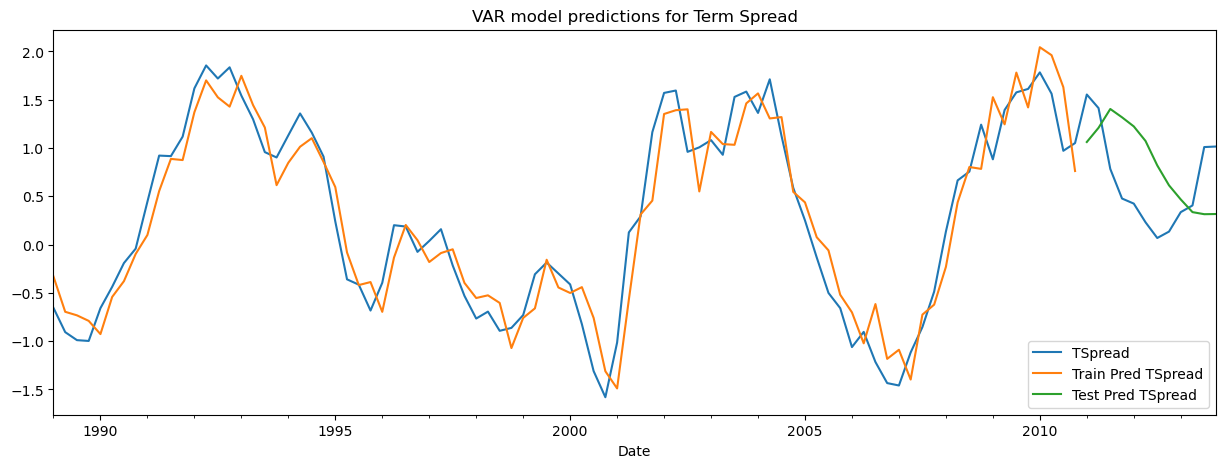

In [43]:
df1.loc[train_idx, 'Train Pred TSpread'] = results.fittedvalues['TSpread']
df1.loc[test_idx, 'Test Pred TSpread'] = fcast[:,1]

plot_cols = ['TSpread', 'Train Pred TSpread', 'Test Pred TSpread']

df1.iloc[-100:][plot_cols].plot(figsize=(15, 5))
plt.title("VAR model predictions for Term Spread");

**The plotted predictions follow a very similar distribution to the VARMA model, including the forecasts. It is difficult to tell whether VAR perform better or worse.**

### Compute R-Squared metric

In [47]:
y_pred = df1.loc[train_idx, 'Train Pred GDPGrowth']
y_true = df1.loc[train_idx, 'GDPGrowth']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]

print("GDP Growth Train R^2:", r2_score(y_true, y_pred))

y_pred = df1.loc[test_idx, 'Test Pred GDPGrowth']
y_true = df1.loc[test_idx, 'GDPGrowth']

print("GDP Growth Test R^2:", r2_score(y_true, y_pred))

GDP Growth Train R^2: 0.2569812409739456
GDP Growth Test R^2: -0.23961760567261248


In [48]:
y_pred = df1.loc[train_idx, 'Train Pred TSpread']
y_true = df1.loc[train_idx, 'TSpread']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]

print("Term Spread Train R^2:", r2_score(y_true, y_pred))

y_pred = df1.loc[test_idx, 'Test Pred TSpread']
y_true = df1.loc[test_idx, 'TSpread']

print("Term Spread Test R^2:", r2_score(y_true, y_pred))

Term Spread Train R^2: 0.8581031996649263
Term Spread Test R^2: -0.6717328659710904


**As expected, the training R2 scores are very similar to the VARMA model, but the test scores are better. The Term Spread test score is not as low, suggesting that VAR is the better model, but it is still not a good fit.**

## Establish baseline with `ARIMA`

In [49]:
for col in cols:
    model = ARIMA(train[col], order=(p, 0, q))
    res = model.fit()
    fcast = res.get_forecast(N_test) 
    y_train = df1.loc[train_idx, col]
    y_test = df1.loc[test_idx, col]
    print(f"{col} Train R^2:", r2_score(y_train, res.fittedvalues))
    print(f"{col} Test R^2:", r2_score(y_test, fcast.predicted_mean))

C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\shmel\Anaconda3\lib\site-packa

GDPGrowth Train R^2: 0.18893318608890963
GDPGrowth Test R^2: -0.45892986851505313
TSpread Train R^2: 0.8300746010118099
TSpread Test R^2: -1.148823877718812


C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**The baseline performs even worse than VARMA and VAR! So at least you know that the vectored time series models outperform naive forecasting with such type of data like econometrics.**